# Multimodal Agentic using OpenAI

Perform tasks or make decisions autonomously based on the tools that are available.

## Inital Setup

In [1]:
import os
import json
import gradio as gr
from dotenv import load_dotenv
from openai import OpenAI

import base64
from io import BytesIO
from PIL import Image

from IPython.display import display, Audio

import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename="chatbot_tools.log", mode="a")
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [2]:
# Local Bot
OLLAMA_API_KEY = "ollama"
OLLAMA_BASE_URL = "http://localhost:11434/v1"
llama_client = OpenAI(api_key=OLLAMA_API_KEY, base_url=OLLAMA_BASE_URL)
llama_model = "llama3.2"

# Online Bot
load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "type-your-api-key-here")
gpt_client = OpenAI()

# Cheapest models
gpt_llm_model = "gpt-4o-mini"
gpt_image_gen_model = "dall-e-2" # best option:"dall-e-3"
gpt_tts_model = "tts-1"

# Tools

In [3]:
# Toy dataset
ticket_prices = {
    "category 1": "Rp1.400.000",
    "category 2": "Rp1.000.000",
    "category 3": "Rp480.000"
}

def get_ticket_price(category: str) -> str:
    print(f"Tool get_ticket_price called for {category}")
    category = category.lower()
    return ticket_prices.get(category)

# Testing
get_ticket_price("category 3")

Tool get_ticket_price called for category 3


'Rp480.000'

In [4]:
get_ticket_price_function = {
    "name": "get_ticket_price",
    "description": "Get football match ticket prices by category. Just call this when a customer asks for the ticket price, for example 'How much is a category ... ticket?'",
    "parameters": {
        "type": "object",
        "properties": {
            "category": {
                "type": "string",
                "description": "The ticket category the customer wants to purchase"
            }
        },
        "required": ["category"],
        "additionalProperties": False
    }
}

In [5]:
tools = [
    {"type": "function", "function": get_ticket_price_function}
]

# Multimodal Implementation

## Image Generator

In [6]:
def artist(category: str, client: OpenAI=gpt_client, model: str=gpt_image_gen_model):
    """Generate ticket background image"""
    
    # Create a prompt
    if category == "category 1":
        view = "from a very close distance "
    elif category == "category 2":
        view = "from a distance that is not close but not far "
    elif category == "category 3":
        view = "from a great distance "
    else:
        view = ""
    image_gen_prompt = f"An image representing supporters watching a football match {view}in a stadium"

    # Call API to generate an image
    image_response = client.images.generate(
        model=model,
        prompt=image_gen_prompt,
        size="1024x1024",
        n=1, #  number of images 
        response_format="b64_json"
    )

    # Convert the generated image
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)

    return Image.open(BytesIO(image_data))

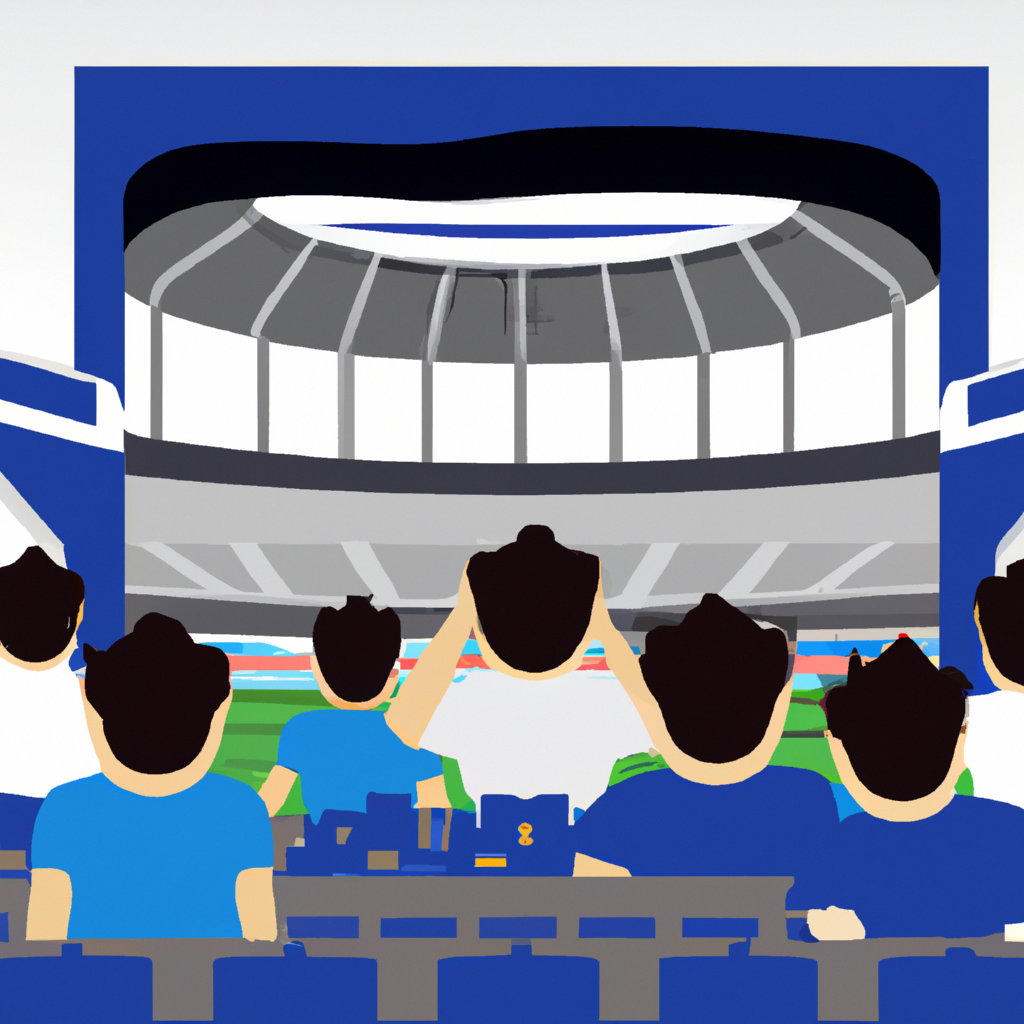

CPU times: total: 641 ms
Wall time: 18.6 s


In [7]:
%%time
test_image = artist("category 2")
display(test_image)

## Audio Generator

In [8]:
def tts(message, client: OpenAI=gpt_client, model: str=gpt_tts_model):
    """Generate audio using text to speech model"""

    # Call API to generate an image
    response = gpt_client.audio.speech.create(
        model=model,
        voice="nova",
        input=message
    )

    # Save the generated audio
    audio_stream = BytesIO(response.content)
    output_filename = "tts_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

In [9]:
# tts("Hello there! Can I help you?")

# Agent Framework

In [10]:
system_message = "You are GBK Assist, a helpful assistant for GBK stadium in Jakarta. "
system_message = "GBK Stadium only provides 3 types of tickets, including category 1, category 2, and category 3."
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."
system_message += "You may use tools only when required. If you can answer the user's question without them, do so."

In [11]:
def handle_tool_call(message) -> tuple:
    responses = []
    temp = None

    for tool_call in message.tool_calls:
        tool_name = tool_call.function.name
        arguments = json.loads(tool_call.function.arguments)

        if tool_name == "get_ticket_price":
            category = arguments.get("category")
            temp = category
            
            ticket_price = get_ticket_price(category)
            content = {"category": category, "ticket_price": ticket_price}
        else:
            content = {"error": f"Unknown tool: {tool_name}"}

        responses.append({
            "role": "tool",
            "content": json.dumps(content),
            "tool_call_id": tool_call.id
        })

    return temp, responses

In [12]:
def chat(history, client: OpenAI=gpt_client, llm_model=gpt_llm_model):
    messages = [{"role": "system", "content": system_message}] + history
    image = None
    
    response = client.chat.completions.create(
        model=llm_model,
        messages=messages,
        tools=tools,
        temperature=0.3
    )

    logging.debug(f"Tool calls status: {response.choices[0].finish_reason}")
    if response.choices[0].finish_reason == "tool_calls":
        tool_message = response.choices[0].message
        tool_calls = tool_message.tool_calls
        temp, tool_responses = handle_tool_call(tool_message)
        messages.append(tool_message)
        messages.extend(tool_responses)

        # Generate image
        if temp:
            if temp in list(ticket_prices.keys()): 
                image = artist(temp)
        
        response = client.chat.completions.create(
            model=llm_model,
            messages=messages,
            temperature=0.3
        )

    # Generate audio
    reply = response.choices[0].message.content
    tts(reply)
    
    history += [{"role": "assistant", "content":reply}]

    return history, image

# UI

In [13]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role": "user", "content": message}]
        return "", history

    entry.submit(
        fn=do_entry,
        inputs=[entry, chatbot],
        outputs=[entry, chatbot]
    ).then(
        fn=chat,
        inputs=[chatbot],
        outputs=[chatbot, image_output]
    )

    clear.click(lambda: None, inputs=None, outputs=[chatbot], queue=False)

ui.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
